# **Musician Classifier Model**
By: Jacob Kao

Date: 9/9/23

### Introduction
The purpose of this notebook is to explore and compare various machine learning methods to maximize facial recognition accuracy. 

### Topics Explored
- Haar Cascade
- Wavelet Transform
- Data cleaning
- Model fine-tuning

Note: the images used in this data set were collected from Google Images using the _Fatkun Batch Image Downloader_ Chrome extension.

### Load Libraries

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

### Identify Face from Image

Load Image

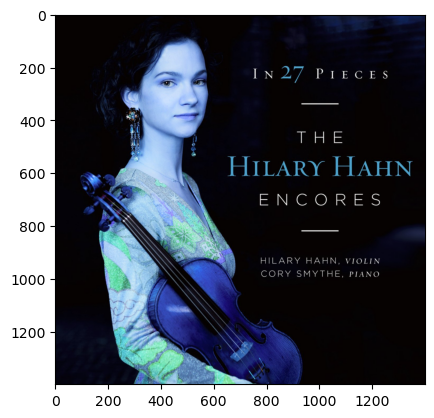

In [2]:
img = cv2.imread("dataset\\test_images\\71EgGyCLFDL.jpg")
plt.imshow(img)

Haar cascades require that the image is black and white, so the image is convered here.

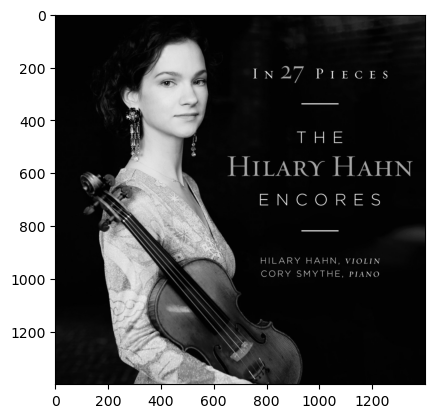

In [3]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')

Using haar cascades, identify the face region of the image. 

In [4]:
#Load the cascade files
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_eye.xml')

#Get x,y,w,h of any faces
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)

#Get x,y,w,h of the first found face
(x, y, w, h) = faces[0]
x, y, w, h

(332, 144, 308, 308)

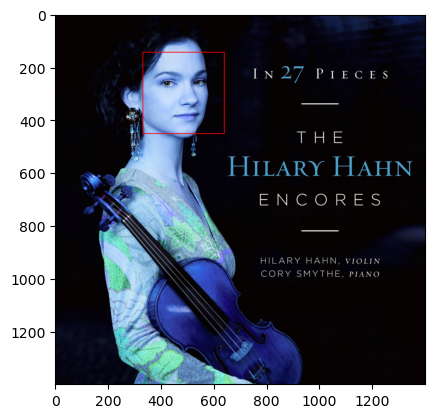

In [5]:
#Draw rectangle around face
face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(face_img)

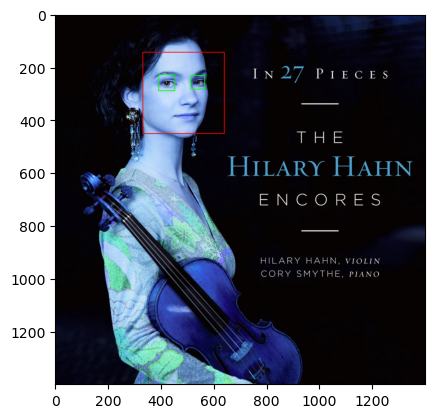

In [6]:
#For all faces found in the image...
for (x,y,w,h) in faces:
    #Draw a red rectangle around the face with line thickness 2
    face_img = cv2.rectangle(img, (x,y), (x+h, y+w), (255, 0, 0), 2)
    roi_gray  = gray_img[y:y+h, x:x+h]
    roi_color = face_img[y:y+h, x:x+h]

    #Draw a green rectangle around all eyes found in the face region
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew, ey+eh), (0, 255, 0), 2)

#Display drawings
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

Crop image to only the region of interest (ROI) for the model.

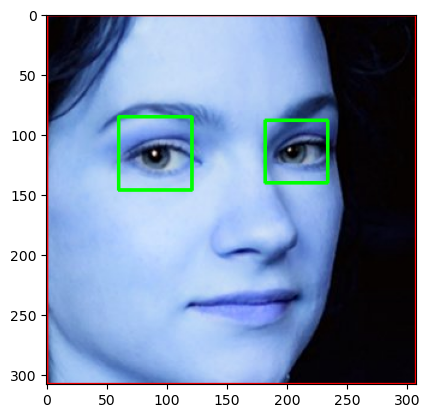

In [7]:
plt.imshow(roi_color, cmap='gray')

Put all previous processes into a single function that crops images if there are more than two eyes detected.

In [8]:
#Condense previous code into single function
#Img path to valid cropped image
def get_cropped_image_if_2_eyes(path):
    #Read image
    img = cv2.imread(path)
    
    

    #Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Detect all faces
    faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
    
    #For each face, detect all eyes within the face region
    for (x,y,w,h) in faces:
        roi_gray = gray_img[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)

        #If there are at least 2 eyes, return image
        if len(eyes) >=2:
            return roi_color

Test the function with an image with a clear face.

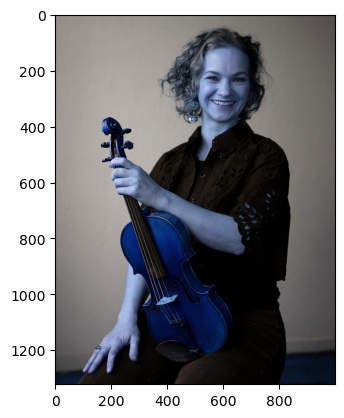

In [9]:
#Load image
original_valid = cv2.imread('./dataset/test_images/Hahn_Hilary_Article.jpg')
plt.imshow(original_valid)

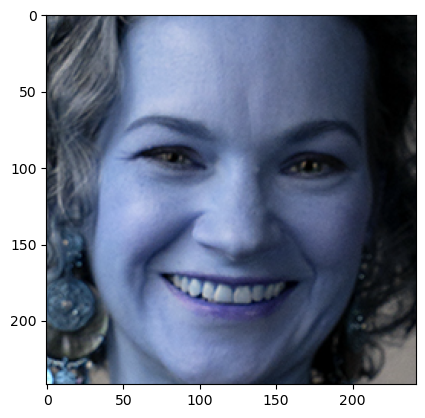

In [10]:
#Test function with image
cropped_valid = get_cropped_image_if_2_eyes('./dataset/test_images/Hahn_Hilary_Article.jpg')
plt.imshow(cropped_valid)

Test function with image having less than two eyes.

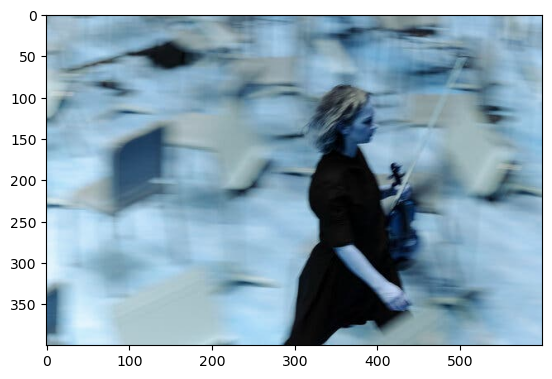

In [11]:
#Test function with invalid image
original_invalid = cv2.imread('./dataset/test_images/14HAHN-01-vwfq-articleLarge.jpg')
plt.imshow(original_invalid)

In [12]:
cropped_invalid = get_cropped_image_if_2_eyes('./dataset/test_images/14HAHN-01-vwfq-articleLarge.jpg')
cropped_invalid 
# (No output)

### Create Dataset for Model 

Create directory for cropped images of each musician.

In [17]:
#Create a cropped folder
dataset_path = "./dataset/"
cropped_dataset_path = './dataset/cropped/'

In [18]:
import os
img_paths = []
for entry in os.scandir(dataset_path):
    if entry.is_dir():
            img_paths.append(entry.path)

img_paths

['./dataset/alexander_malofeev',
 './dataset/augustin_hadelich',
 './dataset/extra_images',
 './dataset/gustavo_dudamel',
 './dataset/hilary_hahn',
 './dataset/ray_chen',
 './dataset/sheku_kanneh_mason',
 './dataset/test_images']

In [19]:
# If cropped directory already exists, delete and remake it
import shutil
if os.path.exists(cropped_dataset_path):
    shutil.rmtree(cropped_dataset_path)
os.mkdir(cropped_dataset_path)

For each musician, create a 'cropped' folder path, crop each image with at least two eyes, properly name each image according to the musician name, and add the image to the respective folder path.

In [20]:
cropped_image_paths = []

#Dictionary of all musician names and their cropped photo paths
musician_file_names_dict = {}

#Get the musicians name from the filepaths
for img_path in img_paths:
    count = 1
    musician_name = img_path.split('/')[-1]
    print(musician_name)

    #Create section in dictionary with musician name
    musician_file_names_dict[musician_name] = []
    
    #For each musician, get all images in that folder
    for entry in os.scandir(img_path):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        print("Current image: ", entry.path)
        #If the image is valid, add to cropped folder with musician name
        if roi_color is not None:
            cropped_folder = cropped_dataset_path + musician_name
            
            #If the folder doesn't already exist, create it
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_paths.append(cropped_folder)

            cropped_file_name = musician_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            musician_file_names_dict[musician_name].append(cropped_file_path)
            count += 1

alexander_malofeev
Current image:  ./dataset/alexander_malofeev\0309_city_pianist-w.jpg
Current image:  ./dataset/alexander_malofeev\1-1-430x538.jpg
Current image:  ./dataset/alexander_malofeev\1.-Alexander-Malofeev-photo-by-Evgeny-Evtyukhov-de8f58f.jpg


Current image:  ./dataset/alexander_malofeev\10.-Alexander-Malofeev-foto-by-Liudmila-Malofeeva-scaled.jpg
Current image:  ./dataset/alexander_malofeev\1559296407_concerto_20malofeev_2012_20febbraio_2.jpg
Current image:  ./dataset/alexander_malofeev\1652204764-1652204764-s0n4a25xduyr.jpg
Current image:  ./dataset/alexander_malofeev\18-22.jpg
Current image:  ./dataset/alexander_malofeev\1_5806828.png
Current image:  ./dataset/alexander_malofeev\2023-10-19_Alexander-Malofeev_800x600-01.jpg
Current image:  ./dataset/alexander_malofeev\299881-concerto-dan-ettinger-alexander-malofeev-2023-ph-l.jpg
Current image:  ./dataset/alexander_malofeev\33286688-4746-47F9-AD130EAADB7F1D36_carouselimage.jpg
Current image:  ./dataset/alexander_malofeev\55213925-10600719-image-a-13_1646962889376.jpg
Current image:  ./dataset/alexander_malofeev\9.-Alexander-Malofeev-foto-by-Liudmila-Malofeeva-scaled.jpg
Current image:  ./dataset/alexander_malofeev\aleksandr-malofeev-andandand-jpg.jpg
Current image:  ./datas

Remove the test images and extra images from the dataset. They will be used later.

In [36]:
cropped_image_paths.remove('./dataset/cropped/test_images')
cropped_image_paths.remove('./dataset/cropped/extra_images')
cropped_image_paths

['./dataset/cropped/alexander_malofeev',
 './dataset/cropped/augustin_hadelich',
 './dataset/cropped/gustavo_dudamel',
 './dataset/cropped/hilary_hahn',
 './dataset/cropped/ray_chen',
 './dataset/cropped/sheku_kanneh_mason']

### Manually delete images in the data set that are not of the correct person.

Some of the identified faces are of people who are not the musician. These faces need to be manually removed from the data set. In a file explorer, go to dataset/cropped/(musician name) and remove any images that are not of the musician before continuing on. 

Update the list of valid directories in the data set after manually deleting unwanted images.

In [66]:
# Replace current dict of files with the new file list after manually deleting unwanted images
for img_path in cropped_image_paths:
    musician_name = img_path.split('/')[-1]
    new_file_list = []
    print("Musician name: ", musician_name)
    if os.path.isfile(img_path):
        for entry in os.scandir(img_path):
            new_file_list.append(entry.path)
        musician_file_names_dict[musician_name] = new_file_list

musician_file_names_dict

Musician name:  alexander_malofeev
Musician name:  augustin_hadelich
Musician name:  gustavo_dudamel
Musician name:  hilary_hahn
Musician name:  ray_chen
Musician name:  sheku_kanneh_mason


{'alexander_malofeev': ['./dataset/cropped/alexander_malofeev/alexander_malofeev1.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev2.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev3.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev4.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev5.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev6.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev7.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev8.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev9.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev10.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev11.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev12.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev13.png',
  './dataset/cropped/alexander_malofeev/alexander_malofeev14.png',
  './dataset/cropped/alexander_malofeev/alexander

### Prepare cropped images for the model

This function's purpose is to convert the cropped image into a wavelet transformed image to allow the model to more clearly identify facial features (eyes, noses, lips, etc.). 

In [67]:
import pywt

def waveletTransform(img, mode='haar', level=1):
    imArray = img
    
    #DATA TYPE CONVERSIONS
    #convert to grayscale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    
    #compute coefficients 
    coeffs = pywt.wavedec2(imArray, mode, level = level)

    #Process Coefficients
    coeffs_H = list(coeffs)  
    coeffs_H[0] *= 0;  

    #Reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)

    return imArray_H

The images need to be converted to a numpy array before they can be transformed.

In [68]:
cropped_img = np.array(roi_color)
cropped_img.shape

(242, 242, 3)

Test the wavelet transform function on an image.

[[ 13  34  57 ...  20  13  10]
 [ 10  29  39 ...  12  13  10]
 [ 22  31  30 ...  13  12   5]
 ...
 [126 123 125 ...   0 255   0]
 [136 136 134 ... 255   0 254]
 [142 140 132 ...   1   0   0]]


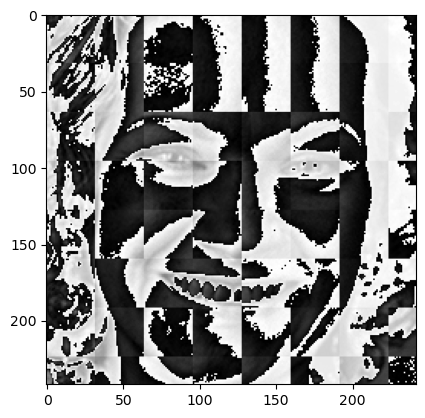

In [69]:
im_har = waveletTransform(cropped_img,'db1',5)
print(im_har)
plt.imshow(im_har, cmap='gray')

Assign a number to each musician to make it easier for the model to make predictions.

In [70]:
#Assign a number to each musician

musician_number_dict = {}
count = 0
for musician_name in musician_file_names_dict.keys():
    if musician_name == 'test_images' or musician_name == 'extra_images':
        continue
    musician_number_dict[musician_name] = count
    count = count + 1

musician_number_dict

{'alexander_malofeev': 0,
 'augustin_hadelich': 1,
 'gustavo_dudamel': 2,
 'hilary_hahn': 3,
 'ray_chen': 4,
 'sheku_kanneh_mason': 5}

### Create X and y for the model

Firstly, all cropped images need to be wavelet transformed. For the model to make its predictions, each raw image is vertically stacked on top of the transformed image.  

In [71]:
#Combine images and convert to number arrays
#   X will consist of a 1D array of a raw image and a wavelet transform
#   y will consist of class labels

X, y = [], []

for musician_name, training_files in musician_file_names_dict.items():
    if musician_name == "test_images" or musician_name == 'extra_images':
        continue
    for training_image in training_files:
        image = cv2.imread(training_image)
        if image is None:
            continue

        wavelet_image = waveletTransform(image, 'db1', 5)
    
        scaled_raw_image = cv2.resize(image, (32, 32))
        scaled_wavelet_image = cv2.resize(wavelet_image, (32, 32))

        #Vertically stack raw and wavelet images
                                            #32 x 32, 3 (RGB)
        combined_image = np.vstack((scaled_raw_image.reshape(32*32*3, 1), scaled_wavelet_image.reshape(32*32, 1)))

        #Create X and y
        X.append(combined_image)
        y.append(musician_number_dict[musician_name])

Each element in X is an array of RGB values representing the raw image over the transformed image. 

Each element in y is the corresponding number of the musician according to the musician dictionary created eariler.

All values in X need to be converted to floats for sklearn. 

In [72]:
# Convert X to floats for sklearn compatibility 
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(193, 4096)

### Model Training

Now that the data set is prepared, the model training can begin.

In [73]:
#SVM 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

Split the data set into training and testing data.

The accuracy of an arbitrary model is tested to ensure the data has been prepared properly.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

#X_train is scaled with standard scaler
pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipeline.fit(X_train, y_train)

print("Pipeline accuracy: ")
pipeline.score(X_test, y_test)

Pipeline accuracy: 


0.8163265306122449

The accuracy the predictions of each musician can be analyized to get a better understanding of the model.

- Precision: How many predicted positives are actually positive
- Recall:    How many positives were correctly predicted in the entire set
- F1-Score:  Mean of Precision and recall
- Support:   How many instances in each set

In [75]:
print(musician_number_dict)
print(classification_report(y_test, pipeline.predict(X_test)))


{'alexander_malofeev': 0, 'augustin_hadelich': 1, 'gustavo_dudamel': 2, 'hilary_hahn': 3, 'ray_chen': 4, 'sheku_kanneh_mason': 5}
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.89      0.89      0.89         9
           2       0.33      0.50      0.40         4
           3       0.80      0.67      0.73         6
           4       0.88      0.88      0.88        17
           5       1.00      0.71      0.83         7

    accuracy                           0.82        49
   macro avg       0.79      0.78      0.78        49
weighted avg       0.84      0.82      0.82        49



### Create Candidate Models

Now that an arbitrary model has been tested, other candidate models can be created to maximize prediction accuracy. 

In [76]:
#Create candidate models
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

The candidate models are:
- Support Vector Machines
- Random Forest
- Logistic Regression
- K-Nearest Neighbors

In [77]:
#Candidates:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    },
    'knn': {
    'model': KNeighborsClassifier(),
    'params': {
        'kneighborsclassifier__n_neighbors': [3, 5, 7],
        'kneighborsclassifier__weights': ['uniform', 'distance'],
        'kneighborsclassifier__p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
        }
    }
}

Train all 4 models and record the best parameters and best accuracy score of each model. 

In [78]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipeline = make_pipeline(StandardScaler(), mp['model'])
    clf      = GridSearchCV(pipeline, mp['params'], cv = 5, return_train_score = False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.736946,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.486207,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.758128,{'logisticregression__C': 1}
3,knn,0.604680,"{'kneighborsclassifier__n_neighbors': 5, 'knei..."


The most accurate model out of the four was the Logistic Regression model.

Next, we test the models using only the best parameters gathered from above.

In [79]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'knn': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier',
                  KNeighborsClassifier(p=1, weights='distance'))])}

In [80]:
#Choosing svm because of slightly better accuracy score
best_estimators['svm'].score(X_test, y_test)

0.8163265306122449

In [81]:
best_estimators['random_forest'].score(X_test, y_test)

0.4897959183673469

In [82]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.8775510204081632

In [83]:
best_estimators['knn'].score(X_test, y_test)

0.7755102040816326

Again, the Logistic Regression model was the most accurate out of the four models.

In [95]:
best_classifier = best_estimators['logistic_regression']

### Viewing Results

In order to view results of the SVM model, a confusion matrix is created.

In [96]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_classifier.predict(X_test))
cm

array([[ 6,  0,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  0],
       [ 0,  0,  2,  1,  1,  0],
       [ 2,  0,  0,  4,  0,  0],
       [ 0,  0,  0,  0, 16,  1],
       [ 0,  0,  1,  0,  0,  6]], dtype=int64)

0 :  alexander_malofeev
1 :  augustin_hadelich
2 :  gustavo_dudamel
3 :  hilary_hahn
4 :  ray_chen
5 :  sheku_kanneh_mason


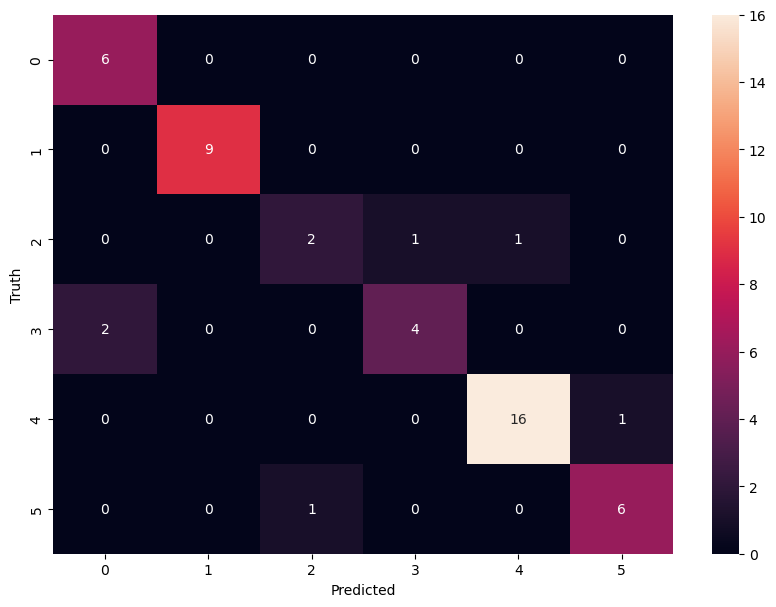

In [97]:
#Visualize confusion matrix with seaborn
import seaborn as sn
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True)

plt.xlabel('Predicted')
plt.ylabel('Truth')

count = 0
for musician in musician_number_dict:
    print(count, ": " ,musician)
    count += 1

#On diagonal:
#Number of times the model correctly guessed 

The numbers across the diagonal represent the number of times the model correctly guessed the musician. The numbers not along the diagonal represent the number of times model guessed incorrectly and the person the model mistook them for. 



### Create a function that guesses the musician

The previous sections of are condenced into a single function which takes in an image path and predicts the name of the musician.  

In [98]:
def guessMusician(image_path):
    image = get_cropped_image_if_2_eyes(image_path)

    if image is None:
        return

    wavelet_image = waveletTransform(image, 'db1', 5)

    scaled_raw_image = cv2.resize(image, (32, 32))
    scaled_wavelet_image = cv2.resize(wavelet_image, (32, 32))

    combined_image = np.vstack((scaled_raw_image.reshape(32*32*3, 1), scaled_wavelet_image.reshape(32*32, 1)))

    combined_image = combined_image.reshape(1, 4096).astype(float)

    combined_image.shape

    prediction = best_classifier.predict(combined_image)
    
    if prediction[0] in musician_number_dict.values():
        # Use a dictionary comprehension to find the name associated with the number
        name_associated_with_number = {name: number for name, number in musician_number_dict.items() if number == prediction[0]}
        
        # Extract the name (assuming the number is unique)
        name = list(name_associated_with_number.keys())[0]
        
        print("Guess: ", name)

### Test Function with images outside of dataset

The following images were outside of the data set to avoid biases. They were then run through the function above to observe the accuracy of the model manually. 

Guess:  gustavo_dudamel


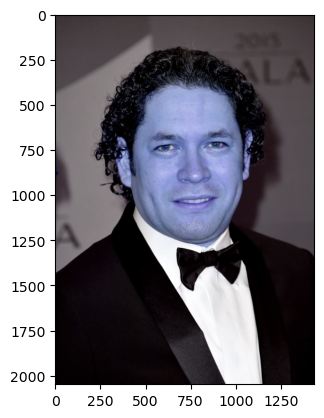

In [99]:
image = cv2.imread('./dataset/extra_images/licensed-image (1).jpg')
plt.imshow(image)
guessMusician('./dataset/extra_images/licensed-image (1).jpg')

Correct!

Guess:  alexander_malofeev


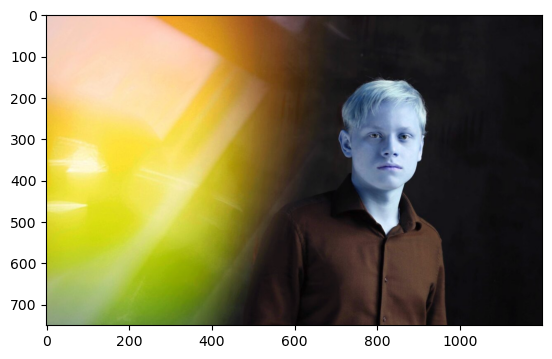

In [100]:
image = cv2.imread('./dataset/extra_images/Alexander-Malofeev-Photo.jpg')
plt.imshow(image)
guessMusician('./dataset/extra_images/Alexander-Malofeev-Photo.jpg')

Correct!

Guess:  hilary_hahn


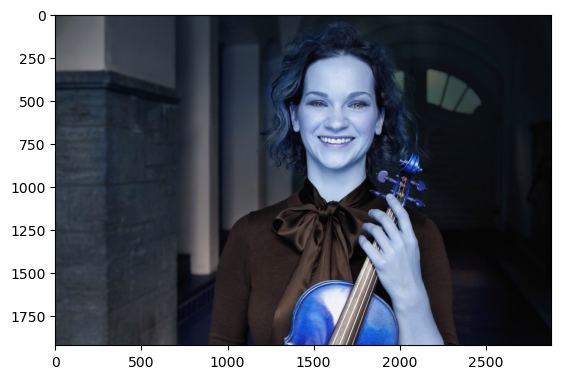

In [101]:
image = cv2.imread('./dataset/extra_images/Hahn-Hilary-02-scaled.jpg')
plt.imshow(image)
guessMusician('./dataset/extra_images/Hahn-Hilary-02-scaled.jpg')

Correct!

Guess:  sheku_kanneh_mason


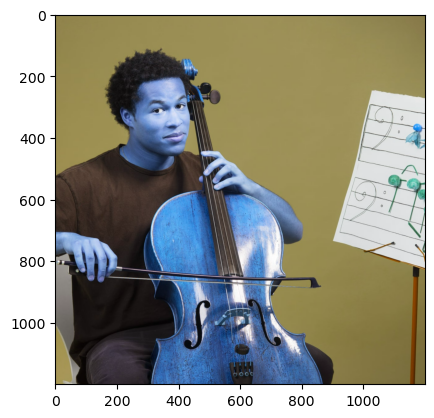

In [102]:
image = cv2.imread('./dataset/extra_images/sheku.png')
plt.imshow(image)
guessMusician('./dataset/extra_images/sheku.png')

Correct!

For fun, I tried running the prediction model on an image of my friend to see what the model would do:

Guess:  augustin_hadelich


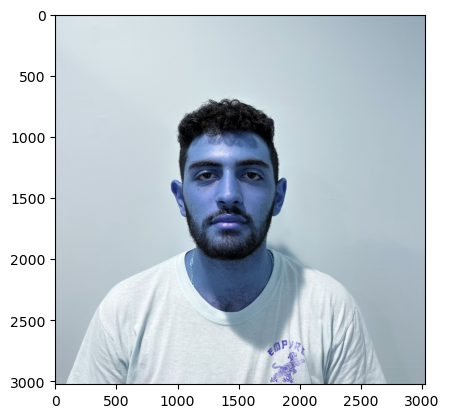

In [103]:
image = cv2.imread('./dataset/extra_images/micheal.jpg')
plt.imshow(image)
guessMusician('./dataset/extra_images/micheal.jpg')

Obviously incorrect.

### Save the Trained Model and Dictionary

In [104]:
import joblib
joblib.dump(best_classifier, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

In [105]:
import json
with open("class_dictionary.json", "w") as f:
    f.write(json.dumps(musician_number_dict))

### Conclusion

Througout this notebook, various machine learning, data cleaning, and classification methods were explored. 

Haar Classifiers were used to obtain the ROI for the data set and to identify valid or invalid images for this project. 

The Logistic Regression model was found to most accuratly classify the images compared to three other models.

Although the goal of this notebook was not to maximize accuracy, future projects of this type should aim to further improve the accuracy of this model as a 80% correctness would not be considered significant in most cases.